# Solution

In [2]:
import pandas as pd
import glob
import email
import re
import nltk
import sklearn

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CSANT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CSANT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\CSANT\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Regular Expressions

In [3]:
def _remove_html_tags(text):
    return re.sub("<[^>]*>", "", text)

def _remove_websites(text):
    
    regex = r'\b((?:[a-z][\w-]+:(?:\/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}\/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’]))'
    return re.sub(regex, "", text)

def _remove_emails(text):
    return re.sub("[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.].+", "", text)

def _lowercase_all(text):
    return text.lower()

def _remove_special_characters(text):
    return re.sub("[^A-Za-z0-9]+", " ", text)

def _remove_numbers(text):
    return re.sub("[0-9]+", "", text)

def _remove_single_letters(text):
    words_list = text.split()
    clean_text_words = []
    for word in words_list:
        if len(word) > 1:
            clean_text_words.append(word)
    return " ".join(clean_text_words)

def _lemmatization_of_words(text):    
    from nltk.stem.porter import PorterStemmer
    clean_text_words = []
    porter = PorterStemmer()
    sentence_words = nltk.word_tokenize(text)
    
    for word in sentence_words:
        clean_text_words.append(porter.stem(word))
    
    return " ".join(clean_text_words)

def _remove_stop_words(text):
    from nltk.corpus import stopwords
    
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words_filtered = []

    for word in words:
        if word not in stop_words:
            words_filtered.append(word)
    
    return " ".join(words_filtered)

def _remove_nonsense_words(text):
    from nltk.corpus import words
    words = set(words.words())
    
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w in words)

In [4]:
def _clean_body_message(body):
    message_without_html_tags = _remove_html_tags(body)

    message_without_websites = _remove_websites(message_without_html_tags)

    message_without_emails = _remove_emails(message_without_websites)

    message_lowercase = _lowercase_all(message_without_emails)

    message_without_numbers = _remove_numbers(message_lowercase)

    message_without_special_characters = _remove_special_characters(message_without_numbers)
    
    message_without_single_letters = _remove_single_letters(message_without_special_characters)
    
    message_without_stop_words = _remove_stop_words(message_without_single_letters)
    
    message_with_correct_words = _remove_nonsense_words(message_without_stop_words)
    
    clean_message = _lemmatization_of_words(message_with_correct_words)
    
    return clean_message

In [5]:
def _get_body_message(all_message):
    b = email.message_from_string(all_message)
    body = ""

    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload()  # decode
                break
    else:
        body = b.get_payload()
    
    return _clean_body_message(body)

# Data Processing

In [6]:
def preprocess_files(files):
    mail_body_messages = []
    for filename in files:
        with open(filename, 'rt', encoding = "ISO-8859-1") as f:
            body_message = _get_body_message(f.read())
            if len(body_message) > 0: # Eliminacion de mensajes que quedaron vacios despues de preprocesamiento
                mail_body_messages.append(body_message)
    return mail_body_messages

In [7]:
first_easy_ham_files = glob.glob("datos/spam-filter/easy_ham/0*")
second_easy_ham_files = glob.glob("datos/spam-filter/easy_ham_2/0*")
first_hard_ham_files = glob.glob("datos/spam-filter/hard_ham/0*")
second_hard_ham_files = glob.glob("datos/spam-filter/hard_ham_2/0*")
first_spam_files = glob.glob("datos/spam-filter/spam/0*")
second_spam_files = glob.glob("datos/spam-filter/spam_2/0*")

first_easy_ham_messages = preprocess_files(first_easy_ham_files)
second_easy_ham_messages = preprocess_files(second_easy_ham_files)
first_hard_ham_messages = preprocess_files(first_hard_ham_files)
second_hard_ham_messages = preprocess_files(second_hard_ham_files)
first_spam_messages = preprocess_files(first_spam_files)
second_spam_messages = preprocess_files(second_spam_files)

# Detect Spam

In [9]:
def get_bag_of_words_dataset(files, is_spam_files):    
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(files).todense()
    dataframe = pd.DataFrame(bag_of_words, columns=vectorizer.get_feature_names())
    
    if is_spam_files:
        dataframe['spam'] = 1
    else:
        dataframe['spam'] = 0
        
    return dataframe

In [10]:
first_easy_ham_dataset = get_bag_of_words_dataset(first_easy_ham_messages, False)
second_easy_ham_dataset = get_bag_of_words_dataset(second_easy_ham_messages, False)
first_hard_ham_dataset = get_bag_of_words_dataset(first_hard_ham_messages, False)
second_hard_ham_dataset = get_bag_of_words_dataset(second_hard_ham_messages, False)
first_spam_dataset = get_bag_of_words_dataset(first_spam_messages, True)
second_spam_dataset = get_bag_of_words_dataset(second_spam_messages, True)

In [13]:
all_df= [first_easy_ham_dataset, second_easy_ham_dataset, first_hard_ham_dataset,
        second_hard_ham_dataset, first_spam_dataset, second_spam_dataset]
spam_df = pd.concat(all_df, axis=0, ignore_index=True)

In [14]:
import seaborn as sns
sns.heatmap(spam_df.isna(),yticklabels=False,cbar=False,cmap='viridis')

In [15]:
spam_df = spam_df.fillna(value=0)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(spam_df.drop('spam', axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
scaled_features = scaler.transform(spam_df.drop('spam',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=spam_df.columns.drop('spam'))

# Model Training

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(scaled_features, 
                                                    spam_df['spam'], test_size=0.30,random_state=101)

In [35]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
predictions = logmodel.predict(X_test)

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

          0       0.99      0.91      0.95      1338
          1       0.80      0.97      0.88       513

avg / total       0.94      0.93      0.93      1851

[[1215  123]
 [  15  498]]


# Neural Network

In [39]:
df_feat.shape

(6170, 12246)

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
import keras

num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [43]:
from keras.layers import Dense 
from keras.models import Sequential 

number_of_features = df_feat.shape[1]
quantity_of_units = [12, 144, 1024, 1078] 

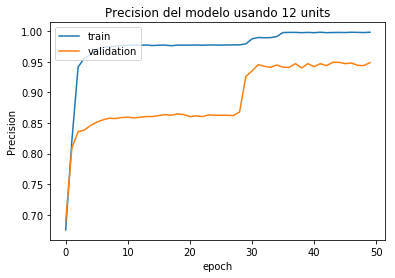

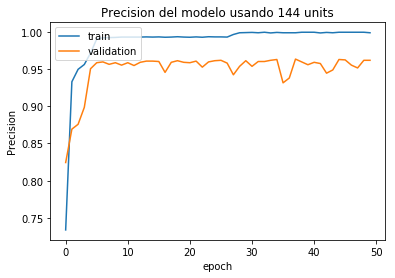

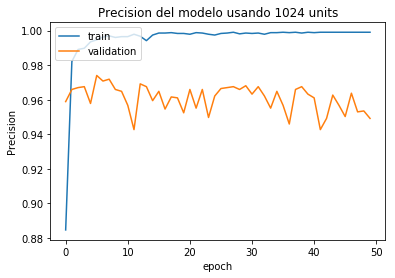

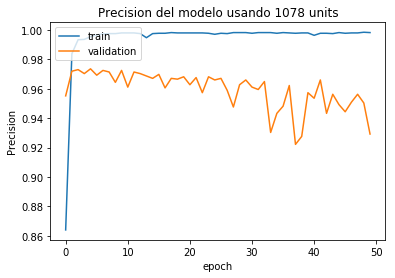

In [45]:
for units in quantity_of_units:
    model=Sequential()
    model.add(Dense(units, input_dim=number_of_features, activation='relu'))
    keras.layers.core.Dropout(rate=0.4) # Creamos una capa oculta para regularizar y evitar sobre-entrenamientos
    model.add(Dense(num_classes,input_dim=number_of_features,activation='softmax')) # Creamos la capa de salida

    # Vamos a usar el optimizador adam para compilar el modelo y vamos a usar la precisión como metrica
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

    # Entrenamos el modelo y hacemos la validación
    history = model.fit(X_train,y_train,epochs=50,verbose=0,batch_size=100,validation_data=(X_test,y_test))
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Precision del modelo usando ' + str(units) + " units")
    plt.ylabel('Precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()